In [1]:
pip install -r requirements_moirai.txt

  Using cached scipy-1.11.4-cp310-cp310-win_amd64.whl.metadata (60 kB)
  Using cached einops-0.7.0-py3-none-any.whl.metadata (13 kB)
  Using cached jaxtyping-0.2.36-py3-none-any.whl.metadata (6.5 kB)
  Using cached python_dotenv-1.0.0-py3-none-any.whl.metadata (21 kB)
  Using cached hydra_core-1.3.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached orjson-3.10.13-cp310-cp310-win_amd64.whl.metadata (42 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached multiprocess-0.70.16-py310-none-any.whl.metadata (7.2 kB)
  Using cached huggingface_hub-0.24.5-py3-none-any.whl.metadata (13 kB)
  Using cached safetensors-0.4.4-cp310-none-win_amd64.whl.metadata (3.9 kB)
  Using cached datasets-2.17.1-py3-none-any.whl.metadata (20 kB)
  Using cached jax-0.4.30-py3-none-any.whl.metadata (22 kB)
  Using cached typing_extensions-4.7.1-py3-none-any.whl.metadata (3.1 kB)
  Using cached omegaconf-2.3.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached antlr4_python3_runtim

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.


In [2]:
pip install --upgrade jaxtyping

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
index = [0, 10, 200, 400, 300]
num_series = len(index)
m4_df = pd.read_csv('../../Hourly-train.csv').iloc[index, 1:101].T
m4_df = m4_df.set_index(pd.date_range(start="2020-01-01 00:00", periods=100, freq='H'))
m4_df

,0,10,200,400,300
2020-01-01 00:00:00,605.0,41889.0,12.6,17.0,12.6
2020-01-01 01:00:00,586.0,41145.0,11.8,20.0,12.1
2020-01-01 02:00:00,586.0,40629.0,11.3,12.0,11.6
2020-01-01 03:00:00,559.0,40281.0,11.0,15.0,11.2
2020-01-01 04:00:00,511.0,39751.0,10.6,11.0,10.8
...,...,...,...,...,...
2020-01-04 23:00:00,710.0,31887.0,13.8,16.0,13.6
2020-01-05 00:00:00,647.0,32703.0,13.5,14.0,12.9
2020-01-05 01:00:00,593.0,33125.0,12.6,12.0,12.4
2020-01-05 02:00:00,564.0,33206.0,12.1,14.0,11.9


# M4

In [3]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
PDT = 12  # prediction length: any positive integer
CTX = 72  # context length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer




ds = PandasDataset(dict(m4_df.iloc[:72]))
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-{SIZE}"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(ds)

c:\Users\Yassine\Desktop\Deepl learning\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
preds = np.stack([c.quantile(.5) for c in forecasts])
preds.shape

(5, 12)

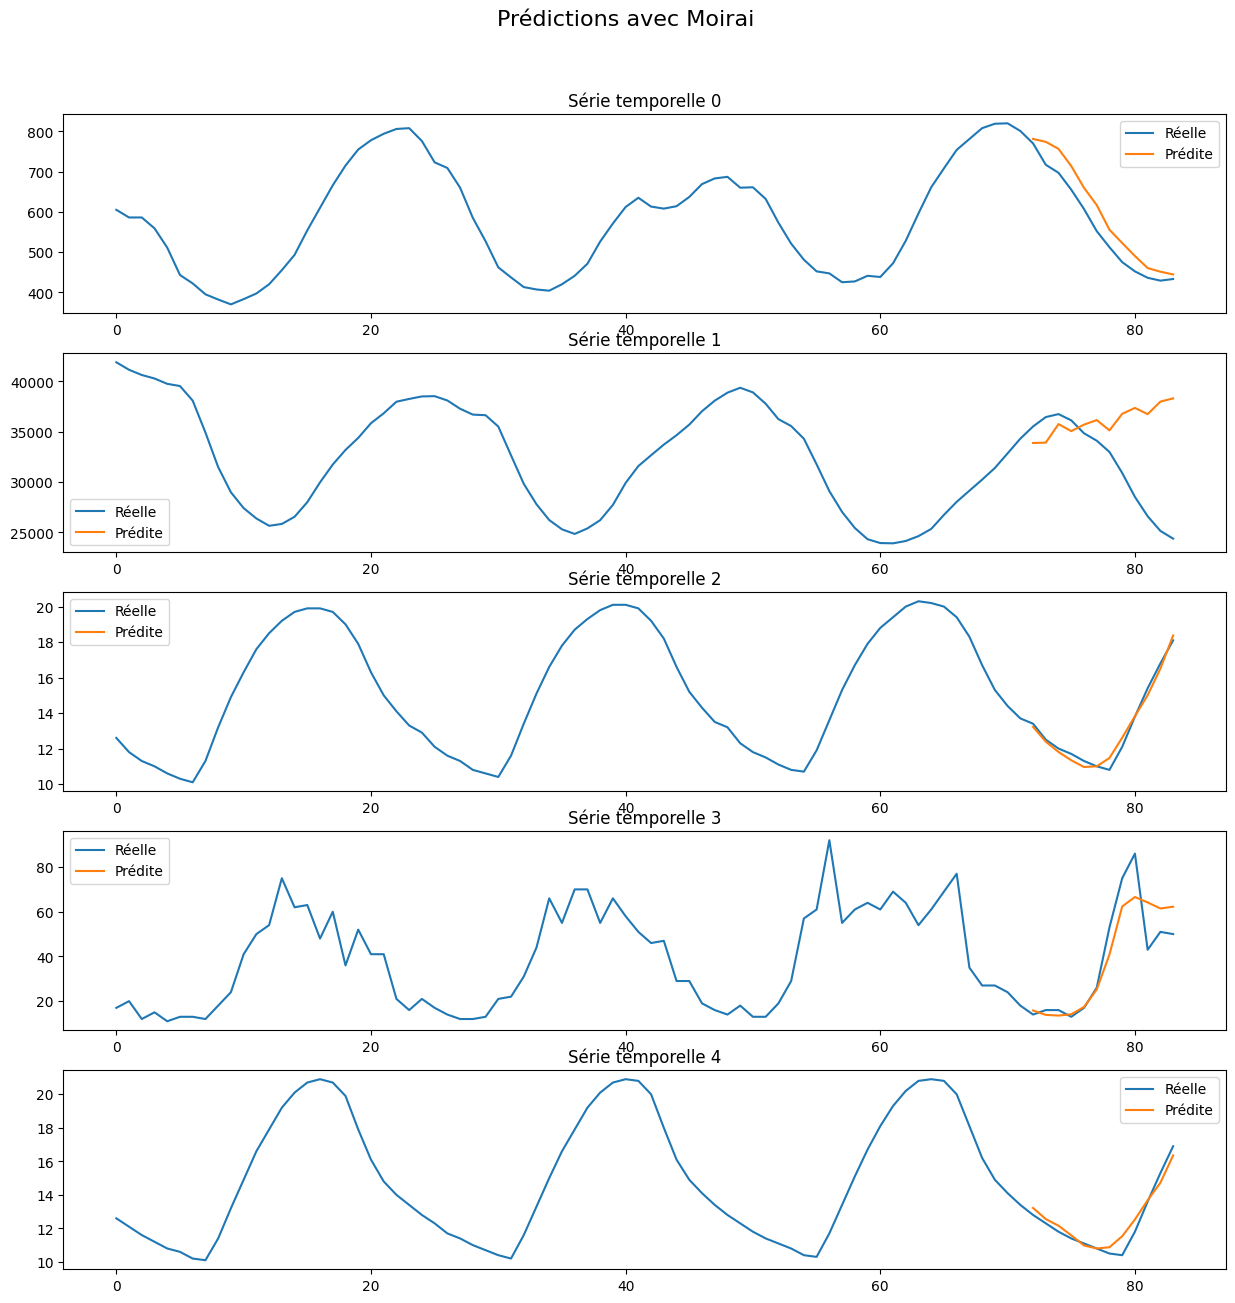

In [5]:
fig, ax = plt.subplots(5, 1, figsize = (15, 15))
fig.suptitle("Prédictions avec Moirai", fontsize=16, y=0.95)
for i in range(num_series):
    ax[i].plot(np.arange(72+12), m4_df.iloc[:72+12, i].values, label = 'Réelle')
    ax[i].plot(np.arange(72, 72+12), preds[i], label = 'Prédite')
    ax[i].set_title(f'Série temporelle {i}')
    ax[i].legend()
plt.show()

In [6]:
mae = np.abs(m4_df.iloc[72:72+12].values - preds.T).mean(axis=0)
mae

array([4.09006297e+01, 5.23906120e+03, 2.78655195e-01, 8.06562964e+00,
       3.98382060e-01])

# Finance

In [23]:
indices = {
    'NASDAQ': '^IXIC',
    'CAC40': '^FCHI',
    'S&P500': '^GSPC'
}

start_date = (pd.Timestamp.now() - pd.DateOffset(years=1)).strftime('%Y-%m-%d')
end_date = pd.Timestamp.now().strftime('%Y-%m-%d')

data = {}
for name, symbol in indices.items():
    df = yf.download(symbol, start=start_date, end=end_date, progress=False)

    df.index = pd.to_datetime(df.index)
    
    if df.index.freq is None:
        df = df.asfreq('D', method='ffill')
    df.index.freq = 'D'
    data[name] = df['Close']


In [25]:
PDT = 31  # prediction length: any positive integer
CTX = 62  # context length: any positive integer

preds = []

for df in data : 
       data[df] = data[df]
       ds = PandasDataset(dict(data[df].iloc[-62-31:-31]))

       model = MoiraiForecast(
       module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-{SIZE}"),
       prediction_length=PDT,
       context_length=CTX,
       patch_size=PSZ,
       num_samples=100,
       target_dim=1,
       feat_dynamic_real_dim=0,
       past_feat_dynamic_real_dim=0,
       )

       predictor = model.create_predictor(batch_size=BSZ)
       forecasts = predictor.predict(ds)

       preds.append(np.stack([c.quantile(.5) for c in forecasts]))

In [43]:
mae = []
for i, df in enumerate(data):
    mae.append(np.abs(data[df].iloc[-31:].values[:, 0]-preds[i][0]).mean())

mae

[300.82339969758067, 132.81207472278226, 66.46663936491936]

# Istanbul Traffic

In [61]:
traffic_df = pd.read_csv('../../istanbul_traffic.csv', index_col = 'datetime').iloc[-1000:]
traffic_df = traffic_df.ffill()
traffic_df.index = pd.date_range('2023-01-01', periods = 1000, freq='T')

In [63]:
PDT = 100  # prediction length: any positive integer
CTX = 900  # context length: any positive integer



ds = PandasDataset(dict(traffic_df.iloc[:900]))



model = MoiraiForecast(
module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-{SIZE}"),
prediction_length=PDT,
context_length=CTX,
patch_size=PSZ,
num_samples=100,
target_dim=1,
feat_dynamic_real_dim=0,
past_feat_dynamic_real_dim=0,
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(ds)

preds2 = (np.stack([c.quantile(.5) for c in forecasts]))

In [70]:
mae = np.mean(np.abs(preds2 - traffic_df.iloc[-100:].T.values), axis=1)
mae

array([4.69153337, 6.06848337, 4.52449737])

# Electricity

In [72]:
def get_ercot():
    url = "https://github.com/ourownstory/neuralprophet-data/raw/main/datasets_raw/energy/ERCOT_load_2004_2021Sept.csv"
    df = pd.read_csv(url).rename(columns = {'y' : 'target'})
    df['ds'] = pd.to_datetime(df['ds'])
    df.ffill(inplace=True)
    ercot_df = df[['ds', 'target']]
    ercot_df['target'] = (ercot_df['target']).astype('float64')
    ercot_df = ercot_df.set_index('ds')
    return ercot_df

In [73]:
ercot_df = get_ercot()
ercot_df

C:\Users\Yassine\AppData\Local\Temp\ipykernel_13276\938499966.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ercot_df['target'] = (ercot_df['target']).astype('float64')


,target
ds,
2004-01-01 01:00:00,22971.94
2004-01-01 02:00:00,22191.52
2004-01-01 03:00:00,21383.44
2004-01-01 04:00:00,20866.56
2004-01-01 05:00:00,20723.15
...,...
2021-08-31 20:00:00,69201.17
2021-08-31 21:00:00,67180.74
2021-08-31 22:00:00,63860.12


In [74]:
window_size = 744 + 24

windows = []
start_indices = np.arange(0, 3 * window_size, window_size)

for start in start_indices:
    window = ercot_df.iloc[start : start + window_size]
    windows.append(window.reset_index(drop=True)["target"])

final_df = pd.DataFrame({f"window_{i+1}": windows[i] for i in range(len(windows))})

final_df = final_df.set_index(pd.date_range("2023-01-01", periods=len(final_df), freq='H'))
final_df


,window_1,window_2,window_3
2023-01-01 00:00:00,22971.94,24763.41,23070.37
2023-01-01 01:00:00,22191.52,24478.03,22209.01
2023-01-01 02:00:00,21383.44,24692.61,21692.63
2023-01-01 03:00:00,20866.56,25325.55,21635.63
2023-01-01 04:00:00,20723.15,26587.99,22201.72
...,...,...,...
2023-02-01 19:00:00,29311.82,31201.36,31980.78
2023-02-01 20:00:00,29196.86,30723.60,30883.87
2023-02-01 21:00:00,28721.74,29415.37,28402.14
2023-02-01 22:00:00,28016.89,27181.40,25501.23


In [76]:
PDT = 24  # prediction length: any positive integer
CTX = 744  # context length: any positive integer




ds = PandasDataset(dict(final_df.iloc[:744]))



model = MoiraiForecast(
module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-{SIZE}"),
prediction_length=PDT,
context_length=CTX,
patch_size=PSZ,
num_samples=100,
target_dim=1,
feat_dynamic_real_dim=0,
past_feat_dynamic_real_dim=0,
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(ds)

preds3 = (np.stack([c.quantile(.5) for c in forecasts]))

In [82]:
mae = np.mean(np.abs(preds3 - final_df.iloc[744:].T), axis=1)
mae

window_1     716.218812
window_2    1019.961279
window_3     824.413646
dtype: float64

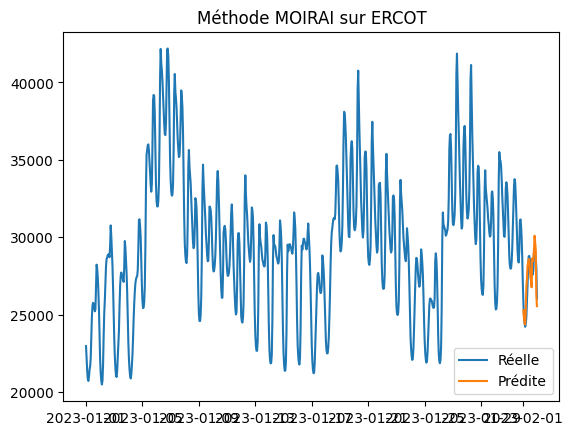

In [86]:
plt.plot(final_df.index, final_df.values[:, 0], label = 'Réelle')
plt.plot(final_df.index[-24:], preds3[0], label = 'Prédite')
plt.title(f'Méthode MOIRAI sur ERCOT')
plt.legend()
plt.show()